In [1]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/FEM')
%load_ext autoreload

In [2]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, PlateBendingResults, Vibration_Mode
from FEMOL_utils import *
from FEMOL_materials import *
import numpy as np
import scipy
from scipy.linalg import sqrtm
import matplotlib.animation as animation
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=110)
from IPython.display import Video
import timeit

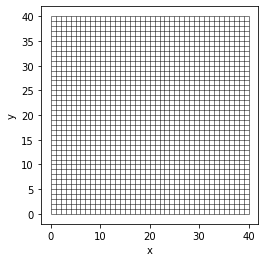

In [3]:
# Create a mesh
Lx = 40
Ly = 40
nelx = Lx
nely = Ly

mesh = RectangleQuadMesh(Lx, Ly, nelx, nely)

# Plot the mesh
mesh.plot(node_numbers=False)

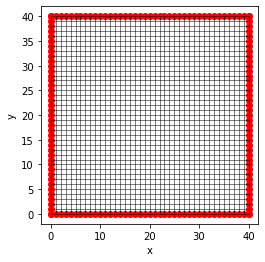

In [4]:
# Create the problem
problem = FEM_Problem('modal', 'plate', mesh)

# Define a material
problem.define_materials(general_isotropic())

# Define a tensor
problem.define_tensors(4, 1)

x = [0, Lx]
y = [[0, Ly]]
domain1 = create_domain(x, y)

x = [[0, Lx]]
y = [0, Ly]
domain2 = create_domain(x, y)

problem.add_fixed_domain(domain1)
problem.add_fixed_domain(domain2)

problem.assemble('K')
problem.assemble('M')
problem.fix_boundary()

problem.plot()

## Sparse eigenvalue solver

In [31]:
K = scipy.sparse.csc_matrix(problem.K)
M = scipy.sparse.csc_matrix(problem.M)

eigen_values, eigen_vectors = scipy.sparse.linalg.eigsh(K, M=M, tol=10e-6, k=100, which='SM')

## Regular eigenvalue solver

As a brief summary, the slowest and the most robust driver is the
    classical ``<sy/he>ev`` which uses symmetric QR. ``<sy/he>evr`` is seen as
    the optimal choice for the most general cases. However, there are certain
    occasions that ``<sy/he>evd`` computes faster at the expense of more
    memory usage. ``<sy/he>evx``, while still being faster than ``<sy/he>ev``,
    often performs worse than the rest except when very few eigenvalues are
    requested for large arrays though there is still no performance guarantee.
    
ev Driver 24.5 s ± 2.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
eigen_values, eigen_vectors = scipy.linalg.eigh(Problem.K, Problem.M, driver='ev', check_finite=False, subset_by_index=[1, 20])

evr Driver 26.3 s ± 4.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
eigen_values, eigen_vectors = scipy.linalg.eigh(Problem.K, Problem.M, driver='evr', check_finite=False, subset_by_index=[1, 20])

evd Driver 24 s ± 1.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
eigen_values, eigen_vectors = scipy.linalg.eigh(Problem.K, Problem.M, driver='evd', check_finite=False, subset_by_index=[1, 20])

evx Driver 23 s ± 2.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
eigen_values, eigen_vectors = scipy.linalg.eigh(Problem.K, Problem.M, driver='evx', check_finite=False, subset_by_index=[1, 20])

In [ ]:
%timeit eigen_values, eigen_vectors = scipy.linalg.eigh(problem.K, problem.M, driver='evx', check_finite=False, subset_by_index=[1, 100])

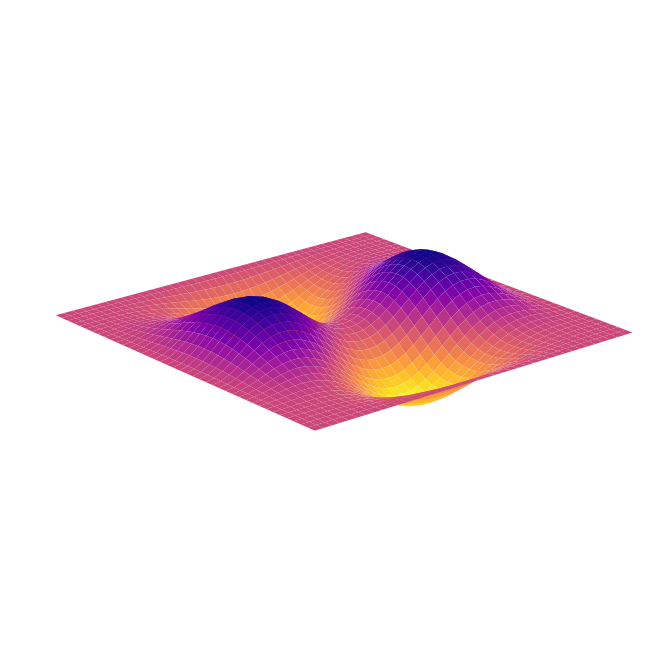

In [30]:
mode = PlateBendingResults(mesh, eigen_vectors[:,4])
mode.Z_displacement_3D(scale=150, azim=50, elev=20)

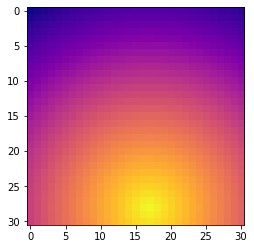

In [37]:
mode.total_displacement_2D()

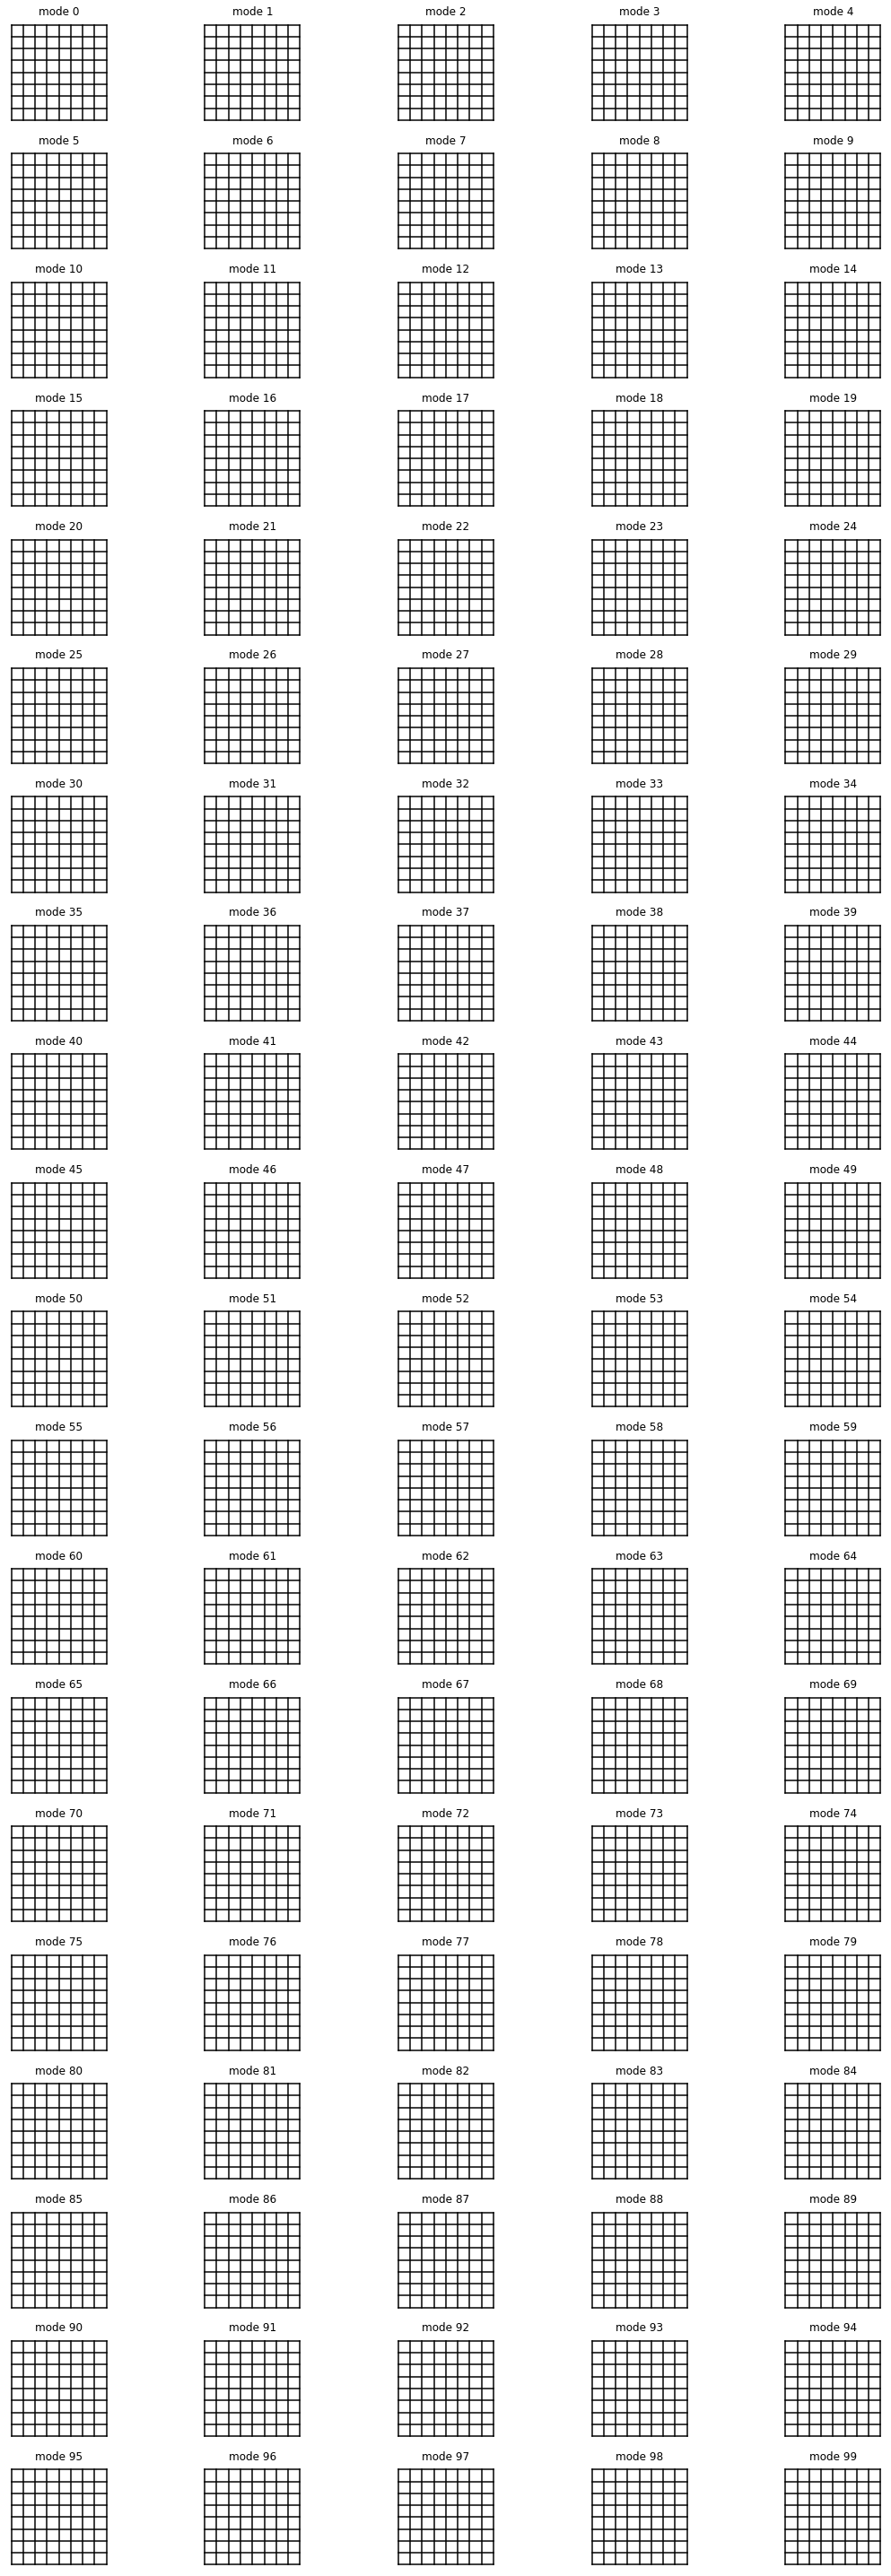

In [65]:
mode=0

fig, axs = plt.subplots(20, 5, figsize=(16,40))
axs = axs.reshape(-1)
scale_factors = np.max(np.abs(eigen_vectors.transpose()), axis=1)/np.max(np.max(np.abs(eigen_vectors.transpose())))
scale=400
skip = 5

for ax, vec, fact in zip(axs, eigen_vectors.transpose(), scale_factors):
    
    result = PlateBendingResults(mesh, vec)
    
    
    X = mesh.xg + result.Ux*scale
    Y = mesh.yg + result.Uy*scale

    for xi, yi in zip(X[:, ::skip].transpose(), Y[:, ::skip].transpose()):
        ax.plot(xi, yi, c='k')

    for xi, yi in zip(X[::skip], Y[::skip]):
        ax.plot(xi, yi, c='k')
    
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_title('mode ' + str(mode))
    mode += 1 

plt.tight_layout()


In [23]:
def cute_mode_plot(PlaneStressResults, scale, skip, **kwargs):
    fig, ax = plt.subplots(figsize=(4.5,4.5))
    
    X = PlaneStressResults.mesh.xg + PlaneStressResults.Ux*scale
    Y = PlaneStressResults.mesh.yg + PlaneStressResults.Uy*scale

    for xi, yi in zip(X[:, ::skip].transpose(), Y[:, ::skip].transpose()):
        ax.plot(xi, yi, c='k', **kwargs)

    for xi, yi in zip(X[::skip], Y[::skip]):
        ax.plot(xi, yi, c='k', **kwargs)
    
    ax.set_axis_off()
    ax.set_aspect('equal')

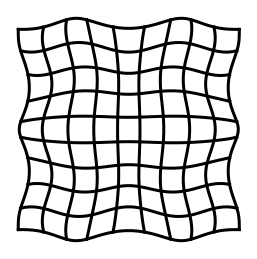

In [30]:
cute_mode_plot(PlaneStressResults(mesh, eigen_vectors.transpose()[25]), 40, 5, linewidth=3)

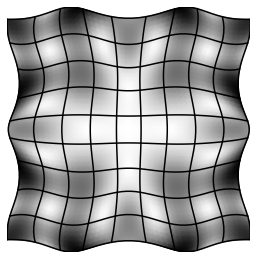

In [12]:
result = PlaneStressResults(mesh, eigen_vectors.transpose()[25])

scale=40

fig, ax = plt.subplots(figsize=(4.5,4.5))
    
X = result.mesh.xg + result.Ux*scale
Y = result.mesh.yg + result.Uy*scale

C = np.zeros((result.Ut.shape[0]-1, result.Ut.shape[1]-1))
for i in range(result.Ut.shape[0]-1):
    for j in range(result.Ut.shape[1]-1):
        C[i, j] = np.mean(result.Ut[i:i+2, j:j+2])
C = C/np.max(C)
        
plt.pcolormesh(X, Y, result.Ut, cmap='Greys', shading='gouraud', vmin=result.Ut.min() + result.Ut.min()/2, vmax=result.Ut.max())

for xi, yi in zip(X[:, ::skip].transpose(), Y[:, ::skip].transpose()):
    ax.plot(xi, yi, c='k')

for xi, yi in zip(X[::skip], Y[::skip]):
    ax.plot(xi, yi, c='k')

ax.set_axis_off()
ax.set_aspect('equal')

In [11]:
vectors=eigen_vectors.transpose()

In [20]:
np.save('vector', eigen_vectors.transpose()[25])

In [21]:
np.save('mesh_coord', mesh.CORG)

In [22]:
mesh.nodes_x

46

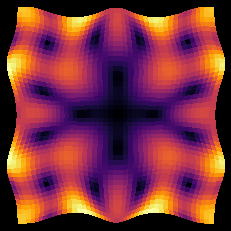

In [18]:
Mode1 = Vibration_Mode(eigen_values[4], eigen_vectors.transpose()[25], mesh)
Dx = Mode1.animate(mesh, 'mode0', scale=40)

In [19]:
Video('mode0.mp4')

In [109]:
Video('allmodes.mp4')

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

array([1., 1., 1., ..., 1., 1., 1.])